# Inaugural Project

In [233]:
# import packages
import warnings
import numpy as np
import matplotlib.pyplot as plt  

# hide runtime warnings
warnings.filterwarnings("ignore")

# import own code
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

#### **Method:**

<font size="4"> The model is solved using the ```HouseholdSpecializationModelClass``` in the following way:
- Create an instance of the class with baseline parameters, $\alpha=0.5$ and $\sigma=1.0$.
- Use ```calc_utility()``` to calculate all the possible utilities, $U$, arising from differents levels of $H_M, H_F, L_M, L_F$.
- Use ```solve_discrete()``` to maximize utility by finding the optimal $H_M, H_F, L_M, L_F$.
- Do this for different values of $\alpha$ and $\sigma$.
</font> 

#### Create instance of the model class:

In [234]:
model = HouseholdSpecializationModelClass()

#### Setup:

In [235]:
# create lists of parameters
sigmas = [0.5, 1.0, 1.5]
alphas = [0.25, 0.5, 0.75]

#### Run model for different values of $\sigma$:

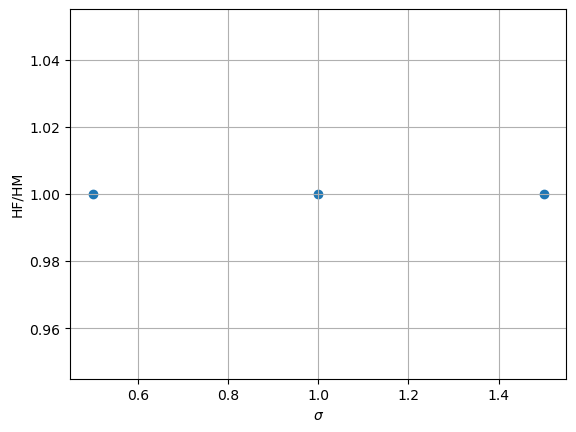

In [236]:
# reset to baseline parameters
model.__init__()

# solve the model for different sigmas
model.solve_multi_par('sigma',sigmas,expand=False,discrete=True)

# plot the solutions for different sigmas
model.plot_multi_par(sigmas,x_lab=r'$\sigma$',y_lab=r'HF/HM')

#### Run model for different values of $\alpha$:

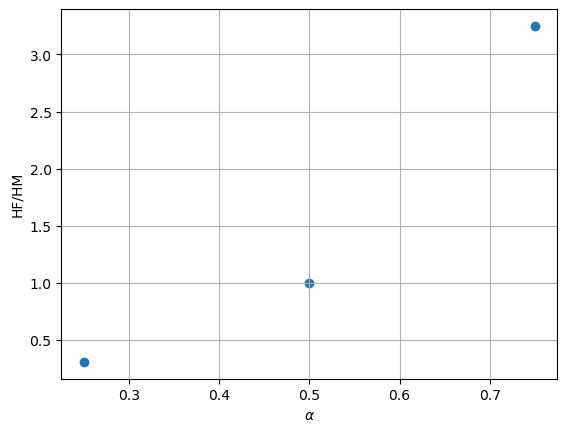

In [237]:
# reset to baseline parameters
model.__init__()

# solve the model for different alphas
model.solve_multi_par('alpha',alphas,expand=False,discrete=True)

# plot the solutions for different alphas
model.plot_multi_par(alphas,x_lab=r'$\alpha$',y_lab=r'HF/HM')

#### **Economic intepretation:**

#### It is evident that the house work ratio, $H_F/H_M$, does not change with the elasticity of substitution, $\sigma$. Each sex works the same amount, though a high elasticity of substitution, $\sigma$, allows them to change their relative workload and keep the same house production. This is because there is no incentive to do so. I.e. each sex is equally productive as $\alpha = 0.5$, and their wages, $w_F$ and $w_M$, are equivalent. However, if we change $\alpha = 0.25$, the house work ratio decreases as the elasticity of subsitution increases:

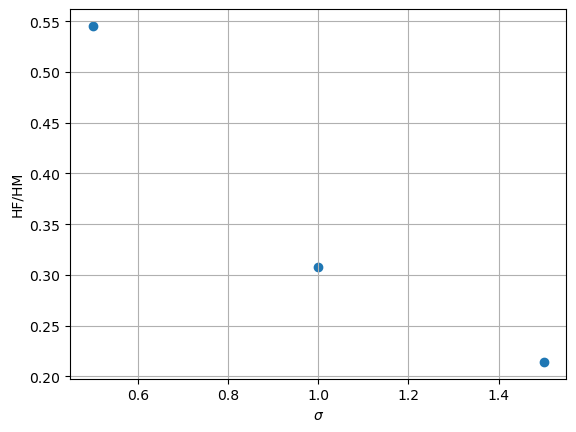

In [238]:
# reset to baseline parameters
model.__init__()

# set alpha to 0.25
setattr(model.par,'alpha',0.25)

# solve the model for different alphas
model.solve_multi_par('sigma',sigmas,expand=False,discrete=True)

# plot the solutions for different alphas
model.plot_multi_par(sigmas,x_lab=r'$\sigma$',y_lab=r'HF/HM')

# Question 2

#### Setup:

In [239]:
# list of wages
wages = [0.8,0.9,1.0,1.1,1.2]

# list of x values for plot
log_wages = [np.log(x/model.par.wM) for x in wages]

#### Run model for different values of $w_F$:

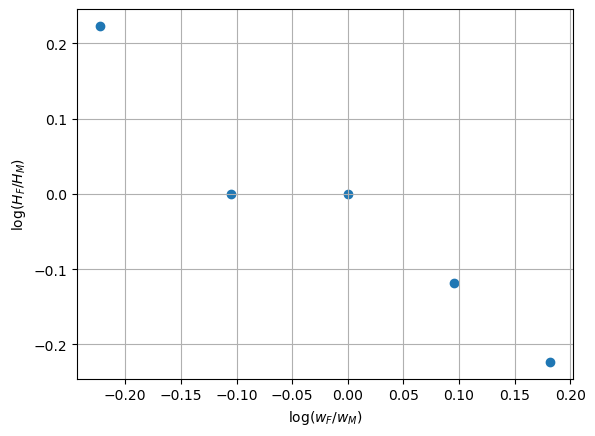

In [240]:
# reset to baseline parameters
model.__init__()

# solve the model for different wages
model.solve_multi_par('wF',wages,expand=False,discrete=True)

# plot the solutions for different wages
model.plot_multi_par(log_wages,
                     y_function=lambda y: np.log(y),
                     x_lab=r'$\log(w_F/w_M)$',
                     y_lab=r'$\log(H_F/H_M)$')

#### **Economic intepretation:**

#### The plot above indicates a negative correlation between the house work ratio, $H_F/H_M$, and the wage ratio, $w_F/w_M$. In other words, when the female wage increases, she tends to do less house work relative to her husband. The elasticity of substitution, $\sigma=1$ in the Cobb-Douglas case, keeps them from completely reallocating such that the female worker does all the market work, while the male worker does all the house work. If $\sigma$ was higher, it would be easier for the couple to reallocate their time. The plot below illustrates this; as $\sigma = 2.0$ it makes the house work ratio, $H_F/H_M$, decrease even more as $w_F$ increases.

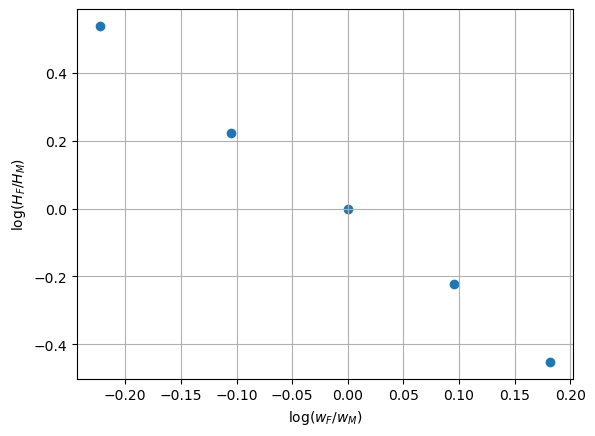

In [241]:
# reset to baseline parameters
model.__init__()

# set sigma to 2.0
setattr(model.par,'sigma',2.0)

# solve the model for different wages
model.solve_multi_par('wF',wages,expand=False,discrete=True)

# plot the solutions for different wages
model.plot_multi_par(log_wages,
                     y_function=lambda y: np.log(y),
                     x_lab=r'$\log(w_F/w_M)$',
                     y_lab=r'$\log(H_F/H_M)$')

# Question 3

#### Now, the model is solved for different wages, $w_F$, but with a continuous choice set by using a numerical optimizer. I use scipy.optimze.minimize with the BFGS method. This is a local minimizer. However, the utility and production functions in this problem are strictly concave, so we don't need to worry about more minimas.

#### The plot of the solutions with a continuous choice set is more smooth than the plot with the discrete choice set. We avoid kinks because of a broader range of possible choices.

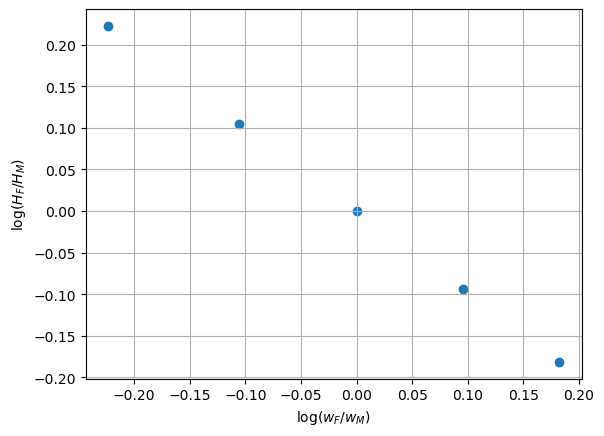

In [242]:
# reset to baseline parameters
model.__init__()

# solve the model for different wages
model.solve_multi_par('wF',wages,expand=False,discrete=False)

# plot the solutions for different wages
model.plot_multi_par(log_wages,
                     y_function=lambda y: np.log(y),
                     x_lab=r'$\log(w_F/w_M)$',
                     y_lab=r'$\log(H_F/H_M)$')

# Question 4

#### The model parameters, $\alpha$ and $\sigma$, are estimated by minimizing the squared deviation from the assumed true $\beta_0 = 0.4$ and $\beta_1 = -0.1$. That is

#### $\min_{\alpha, \sigma} \hspace{0.2cm} (\beta_0 - \hat{\beta}_0)^2 +(\beta_1 - \hat{\beta}_1)^2$.

<font size="4"> This is done using a numerical optimizer to find the **global** minimium. I use scipy.optimize.differential_evolution. The process is:
- Guess on parameters, $\alpha$ and $\sigma$.
- Solve the model continouosly for each $w_F$.
- Calculate resulting $\log(H_F/H_M)$ and $\log(w_F/w_M)$.
- Run regression and get the estimated $\hat{\beta}_0$ and $\hat{\beta}_1$.
- Calculate the squared deviation from $\beta_0$ and $\beta_1$.
- Make new guess on $\alpha$ and $\sigma$ or end if converged.

Note that the estimation is done with bounds $\alpha \in [0,1]$ and $\sigma \in [0,2]$.
<font>

In [243]:
# set baseline parameters
model.__init__()

# estimate model
est = model.estimate(expand=False)

#### Get estimates (```x[0]``` $= \sigma$ and ```x[1]``` $= \alpha$):

In [244]:
print(est.x) # sigma, alpha
print(est.fun) # squared deviation

[0.10702408 0.97702555]
5.2405186340905214e-05


#### **Estimation results:** Low $\sigma=0.11$ and high $\alpha=0.98$.

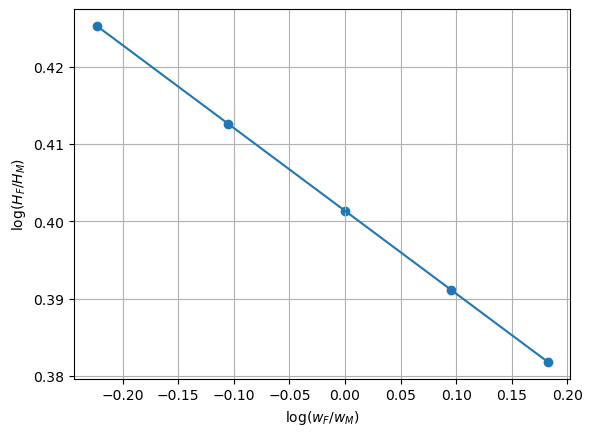

In [245]:
# plot
model.plot_multi_par(log_wages,
                     y_function=lambda y: np.log(y),
                     x_lab=r'$\log(w_F/w_M)$',
                     y_lab=r'$\log(H_F/H_M)$',
                     show_reg=True)

#### **Economic interpretation:**

#### The estimated $\beta_1$ by Siminski and Yetsenga (2002) suggests that the house work ratio, $H_F/H_M$, decreases by 0,1 pct. when the wage ratio, $w_F/w_M$, increases by 1 pct. One could argue that this is a relatively weak relationship compared to what one would expect. Intuitively, one would expect the female worker to do much less house work, $H_F$, if her wage increased relative to the male wage.<b>

#### To account for this weak correlation, $\beta_1=-0.1$, the model estimation perfomed above results in a high $\alpha$ and a low $\sigma$. That is, the only way the present model can explain the weak correlation is if the female worker is far more productive at home, high $\alpha$, and the couple cannot easily substitute house work between them, low $\sigma$. 

#### In other words, when the female wage, $w_F$ increases relative to the male wage, $w_M$, the couple cannot afford to reallocate their time such that the female partner does less house work, $H_F \downarrow$, beacuse 1) the female partner is far more productive at house work than the male partner (high $\alpha$), and 2) both partners much contribute a lot to achieve high $H$ (low $\sigma$).

# Question 5

#### **Model expansion:**

#### If both sexes are equally productive at home, $\alpha = 0.5$, then an alternative explaination for the weak correlation between $H_F/H_M$ and $w_F/w_M$ could be that the female partner gets more utility from house work or that the male partner gets more disutility from house work. Consider the model with $\epsilon_M$ and $\epsilon_F$ allowing for different disutility from house work for each sex:

\begin{align*}
\text{Utility} &= \frac{Q^{1-\rho}}{1-\rho} - v \left( \text{Disutility}_M + \text{Disutility}_F \right) \\
\text{Disutility}_M &= \frac{H_M^{1+1/\epsilon_M}}{1+1/\epsilon_M} + \frac{L_M^{1+1/\epsilon}}{1+1/\epsilon} \\

\text{Disutility}_F &= \frac{H_F^{1+1/\epsilon_F}}{1+1/\epsilon_F} + \frac{L_F^{1+1/\epsilon}}{1+1/\epsilon}
\end{align*}

#### As the marginal disutility is increasing for decreasing $\epsilon$, we can set $\epsilon_M = 0.60$ and $\epsilon_F = 1.00$ such that the male partner gets more marginal disutility from house work relative to the female partner. The disutility from market labor, $L_M$ and $L_F$, is kept equivalent for both sexes with $\epsilon = 1.0$.



In [246]:
# reset baseline
model.__init__()

# set epsilonM and epsilonF
model.par.epsilonM = 0.6
model.par.epsilonF = 1.0

# estimate model - expand = True estimates the expanded model
est_new = model.estimate(expand=True)

#### Get estimates (```x[0]``` $= \sigma$ and ```x[1]``` $= \alpha$):

In [247]:
print(est_new.x) # sigma, alpha
print(est_new.fun) # squared deviation

[0.91142578 0.48457031]
0.006324364747328822


#### **Estimation results:** Now, $\alpha$ is approximately equal to 0.5 reflecting that each sex is equally productive at house work. In the expanded model, the weak correlation between $H_F/H_M$ and $w_F/w_M$ could be explained by the idea that the male partner gets more disutility from housework.